In [1]:
import numpy as np
from importlib import reload
import fdc
fdc=reload(fdc)
import matplotlib.pyplot as plt

In [2]:
N = 83
x = np.random.randn(N, 1000) / np.sqrt(N)
np.shape(np.triu(x))

(83, 1000)

In [3]:
time_step = 1
frequency = 250
n_chunks = 1

In [4]:
s = fdc.correlation_freq(x,time_step,frequency)

In [5]:
np.shape(s) #matrixe di correlazione integrate

(83, 83)

In [6]:
np.mean(np.diag(s).real)

9.949691617307652e-06

In [7]:
sii = []
for freq in np.linspace(1,50,1000):
    s = fdc.correlation_freq(x,time_step,freq)
    smean = np.mean(np.diag(s).real)
    #print(smean)
    sii.append(smean)
    

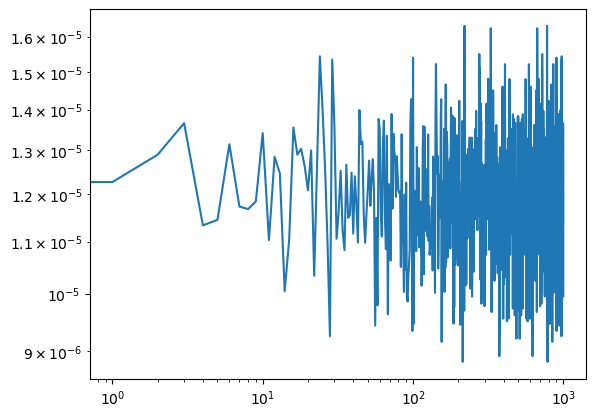

In [8]:
plt.plot(sii)
plt.xscale('log')
plt.yscale('log')


In [420]:
def generate_OU(J, T=20000, dt=1, sigma=1.0, g=None):
    """
    Generate multivariate Ornstein-Uhlenbeck (OU) process.
    
    Parameters
    ----------
    N : number of nodes
    T : number of time points
    dt : timestep in seconds
    g : global coupling (scales J)
    sigma : noise amplitude

    Returns
    -------
    X : array shape (N, T)
        OU time series ready to use with correlation_freq()
    """
    # Random Gaussian connectivity (consistent with the paper's theory)

    N = len(J)

    if g == None:
        lambdamax = np.max(np.linalg.eigvals(J))
        g = 1/lambdamax - 0.1
    
    X = np.zeros((N, T))
    noise_scale = np.sqrt(sigma * dt)

    for t in range(T-1):
        drift = (-X[:, t] + g * J @ X[:, t])
        noise = noise_scale * np.random.randn(N) 
        X[:, t+1] = X[:, t] + dt * drift + noise

    # Removing transient (optional)
    return X#[:, 5000:]   # discard first 5k samples


In [745]:
N = 83
A = np.random.randn(N, N) / np.sqrt(N)
J = (A + A.T) / 2

In [746]:
tp = 128
T = tp*30
dt=1/tp
x = generate_OU(J, T, dt, g=None)

In [747]:
N

83

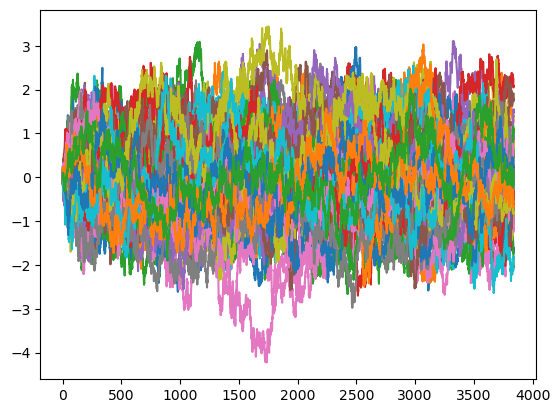

In [748]:
plt.plot(x.T);

In [749]:
np.shape(x)

(83, 3840)

In [750]:
x.shape = (N, T)   # Your OU data
dt  

0.0078125

In [751]:
freqs = np.linspace(0.0001, 100, 1000) #np.logspace(-3, 2., 50)  
omegas = 2 * np.pi * freqs

In [752]:
freqs

array([1.00000e-04, 1.00200e-01, 2.00300e-01, 3.00400e-01, 4.00500e-01,
       5.00600e-01, 6.00700e-01, 7.00800e-01, 8.00900e-01, 9.01000e-01,
       1.00110e+00, 1.10120e+00, 1.20130e+00, 1.30140e+00, 1.40150e+00,
       1.50160e+00, 1.60170e+00, 1.70180e+00, 1.80190e+00, 1.90200e+00,
       2.00210e+00, 2.10220e+00, 2.20230e+00, 2.30240e+00, 2.40250e+00,
       2.50260e+00, 2.60270e+00, 2.70280e+00, 2.80290e+00, 2.90300e+00,
       3.00310e+00, 3.10320e+00, 3.20330e+00, 3.30340e+00, 3.40350e+00,
       3.50360e+00, 3.60370e+00, 3.70380e+00, 3.80390e+00, 3.90400e+00,
       4.00410e+00, 4.10420e+00, 4.20430e+00, 4.30440e+00, 4.40450e+00,
       4.50460e+00, 4.60470e+00, 4.70480e+00, 4.80490e+00, 4.90500e+00,
       5.00510e+00, 5.10520e+00, 5.20530e+00, 5.30540e+00, 5.40550e+00,
       5.50560e+00, 5.60570e+00, 5.70580e+00, 5.80590e+00, 5.90600e+00,
       6.00610e+00, 6.10620e+00, 6.20630e+00, 6.30640e+00, 6.40650e+00,
       6.50660e+00, 6.60670e+00, 6.70680e+00, 6.80690e+00, 6.907

In [753]:
freqs

array([1.00000e-04, 1.00200e-01, 2.00300e-01, 3.00400e-01, 4.00500e-01,
       5.00600e-01, 6.00700e-01, 7.00800e-01, 8.00900e-01, 9.01000e-01,
       1.00110e+00, 1.10120e+00, 1.20130e+00, 1.30140e+00, 1.40150e+00,
       1.50160e+00, 1.60170e+00, 1.70180e+00, 1.80190e+00, 1.90200e+00,
       2.00210e+00, 2.10220e+00, 2.20230e+00, 2.30240e+00, 2.40250e+00,
       2.50260e+00, 2.60270e+00, 2.70280e+00, 2.80290e+00, 2.90300e+00,
       3.00310e+00, 3.10320e+00, 3.20330e+00, 3.30340e+00, 3.40350e+00,
       3.50360e+00, 3.60370e+00, 3.70380e+00, 3.80390e+00, 3.90400e+00,
       4.00410e+00, 4.10420e+00, 4.20430e+00, 4.30440e+00, 4.40450e+00,
       4.50460e+00, 4.60470e+00, 4.70480e+00, 4.80490e+00, 4.90500e+00,
       5.00510e+00, 5.10520e+00, 5.20530e+00, 5.30540e+00, 5.40550e+00,
       5.50560e+00, 5.60570e+00, 5.70580e+00, 5.80590e+00, 5.90600e+00,
       6.00610e+00, 6.10620e+00, 6.20630e+00, 6.30640e+00, 6.40650e+00,
       6.50660e+00, 6.60670e+00, 6.70680e+00, 6.80690e+00, 6.907

In [754]:
C_freq = np.zeros((N, N, len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(freqs):
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=10,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


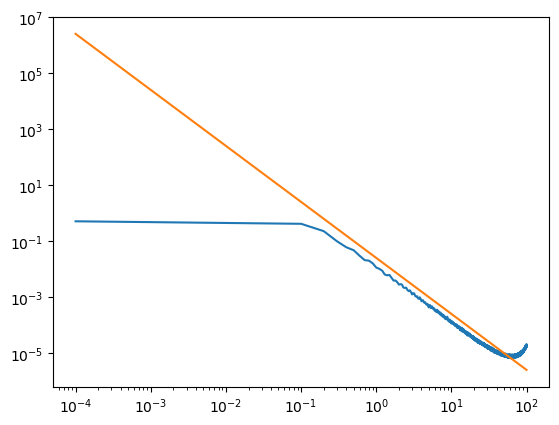

In [755]:
plt.loglog(freqs,S_ii)
plt.plot(freqs,1/omegas**2)
#plt.xlim(10e0,10)

In [756]:
freqs

array([1.00000e-04, 1.00200e-01, 2.00300e-01, 3.00400e-01, 4.00500e-01,
       5.00600e-01, 6.00700e-01, 7.00800e-01, 8.00900e-01, 9.01000e-01,
       1.00110e+00, 1.10120e+00, 1.20130e+00, 1.30140e+00, 1.40150e+00,
       1.50160e+00, 1.60170e+00, 1.70180e+00, 1.80190e+00, 1.90200e+00,
       2.00210e+00, 2.10220e+00, 2.20230e+00, 2.30240e+00, 2.40250e+00,
       2.50260e+00, 2.60270e+00, 2.70280e+00, 2.80290e+00, 2.90300e+00,
       3.00310e+00, 3.10320e+00, 3.20330e+00, 3.30340e+00, 3.40350e+00,
       3.50360e+00, 3.60370e+00, 3.70380e+00, 3.80390e+00, 3.90400e+00,
       4.00410e+00, 4.10420e+00, 4.20430e+00, 4.30440e+00, 4.40450e+00,
       4.50460e+00, 4.60470e+00, 4.70480e+00, 4.80490e+00, 4.90500e+00,
       5.00510e+00, 5.10520e+00, 5.20530e+00, 5.30540e+00, 5.40550e+00,
       5.50560e+00, 5.60570e+00, 5.70580e+00, 5.80590e+00, 5.90600e+00,
       6.00610e+00, 6.10620e+00, 6.20630e+00, 6.30640e+00, 6.40650e+00,
       6.50660e+00, 6.60670e+00, 6.70680e+00, 6.80690e+00, 6.907

In [757]:
N = 84
T = 30000
A = np.random.randn(int(N/2), int(N/2)) / np.sqrt(int(N/2))
J = (A + A.T) / 2
g = 0.1
if g < 1: 
    alpha = 1/(2*g)+0.1
else:
    alpha = 1/(2*g)-0.1
beta = 100
W = np.block([
        [ alpha * J,  -beta * J ],
        [ beta  * J,   alpha * J ]
    ])

In [758]:
np.shape(W)

(82, 82)

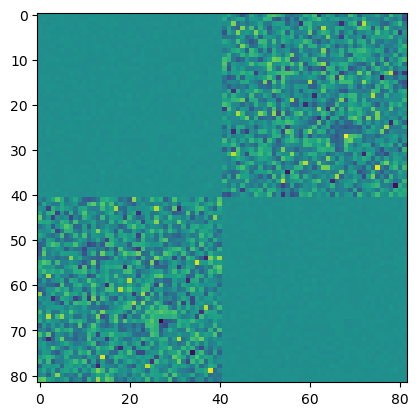

In [759]:
plt.imshow(W)

In [760]:
x = generate_OU(W, T, dt, g=g)

In [761]:
#plt.plot(x)
#plt.show()

In [762]:
T

30000

In [763]:
x.shape = (x.shape[0], T)   # Your OU data
dt  

0.0078125

In [771]:
C_freq = np.zeros((x.shape[0], x.shape[0], len(freqs)), dtype=complex)
S_ii = []

for i, f in enumerate(freqs):
    cif = fdc.correlation_freq(
        x,
        time_step=dt,
        frequency=f,
        n_chunks=100,          # important for unbiased estimator
        corr_type="covariance"
    )
    C_freq[:, :, i] = cif
    S_ii.append(np.mean(np.diag(cif)))


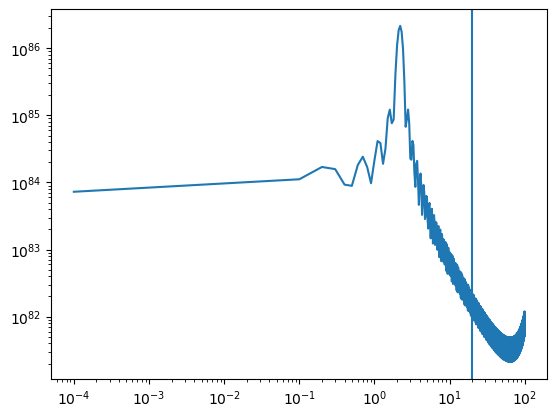

In [772]:
plt.loglog(freqs,S_ii)
#plt.plot(freqs,1/omegas**2*10e12) 
plt.axvline(2*g*beta)

In [773]:
np.argmax(S_ii)

22

In [774]:
freqs[np.argmax(S_ii)]

2.2023

In [768]:
2*g*beta

20.0

In [769]:
f

100.0